# Project Description

**Develop a feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.**

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

* **Thumbs up**:  Increase the volume
* **Thumbs down**: Decrease the volume
* **Left swipe**: 'Jump' backwards 10 seconds
* **Right swipe**: 'Jump' forward 10 seconds  
* **Stop**: Pause the movie

[Data Source](https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL)

## Objectives

**Generator**: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

**Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

**Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
# load library
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

>We set the random seed so that the results don't vary drastically each run of the files.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines()) #train data details
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())     #validation data details
batch_size = 15                                                                              #started with lower batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

>Data Processing:

>>•	Deciding on number of images to be taken per video/sequence

>>•	Resizing  and cropping the images : This was mainly done to ensure that the Neural network only recognizes the gestures effectively rather than focusing on the other background noise present in the image. We used 120 by 120 image size after experimenting with different sizes.

>>•	Normalizing the images : Normalizing the RGB values of an image can at times be a simple and effective way to get rid of distortions caused by lights and shadows in an image.


In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # -------------- LIST CREATION
    #create a list of image numbers you want to use for a particular video, we are not using all the 30 images in a video, selected pickup of images
    img_idx = [x for x in range(0,30,2)]
    
    while True:
        t = np.random.permutation(folder_list)
        
        # -------------- INITIALISATION OF BATCH
        # calculate the number of batches
        num_batches =int(len(t)/batch_size) 
         # we iterate over the number of batches
        for batch in range(num_batches):
            x=len(img_idx)
            y=120
            z=120
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,x,y,z,3)) 
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5)) 
            cnt_img=0
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                cnt_img+=1
                # ------------------ LOOPING DATA POINTS
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # ------------------ NORMALIZE
                    norm_image=image/255.0
                    
                    # ------------------ RESIZE
                    image_resized=resize(norm_image,(120,120),mode='reflect')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        cnt_img=0
        batch_cover = num_batches*batch_size
        rem = len(t) - batch_cover
        if(len(t)!=batch_cover):
            for folder in range(rem):
                imgs = os.listdir(source_path+'/'+ t[folder + batch_cover].split(';')[0]) # read all the images in the folder
                cnt_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + batch_cover].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    norm_image = image/255.0 # normalizing the image 
                    image_resized=resize(norm_image, (120,120), mode='reflect')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + batch_size].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, TimeDistributed,Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from keras.layers.convolutional import Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from keras.regularizers import l2

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
def train_model( model):
        # Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
        train_generator = generator(train_path, train_doc, batch_size)
        val_generator = generator(val_path, val_doc, batch_size)

        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/' #file name
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5' #file path

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1) #chekpoints to save model in .h5
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001) #learning Rate
        callbacks_list = [checkpoint, LR]

        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1 #in case of remaining data points which are left after full batches

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1 #in case of remaining data points which are left after full batches
            
        # Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


In [8]:
# plot accuracy & loss graph for training & validation results
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [9]:
def plot_2(history):
    plt.plot(trained_model.history['categorical_accuracy'])
    plt.plot(trained_model.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Model 1 : Conv2D layers + GRU Layer+ Adam optimiser + No dropout

In [10]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15


# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu'))
model.add(Dense(num_denselayers[1], activation='relu'))

## using GRU as the RNN model
model.add(GRU(64, return_sequences=False))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

2023-03-11 22:10:11.666026: W tensorflow/stream_executor/platform/default/dso_loader.cc:65] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-11 22:10:11.666079: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-11 22:10:11.666108: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


In [11]:
from tensorflow.keras.optimizers import Adam
optimiser = "Adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 60, 60, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 60, 60, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 30, 30, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 30, 30, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 30, 30, 32)   1

In [12]:
print("Total Params:", model.count_params())
trained_model_1=train_model(model)

Total Params: 152453
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_369/2256448371.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.2147 - categorical_accuracy: 0.4963Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 1.72147, saving model to model_init_2023-03-1122_10_07.194785/model-00001-1.21468-0.49630-1.72147-0.24762.h5
45/45 [==============================] - 145s 3s/step - loss: 1.2147 - categorical_accuracy: 0.4963 - val_loss: 1.7215 - val_categorical_accuracy: 0.2476 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 0.8005 - categorical_accuracy: 0.7111
Epoch 00002: val_loss did not improve from 1.72147
45/45 [==============================] - 139s 3s/step - loss: 0.8005 - categorical_accuracy: 0.7111 - val_loss: 2.1632 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.5384 - categorical_accuracy: 0.7970
Epoch 00003: val_loss did not improve from 1.72147
45/45 [======================

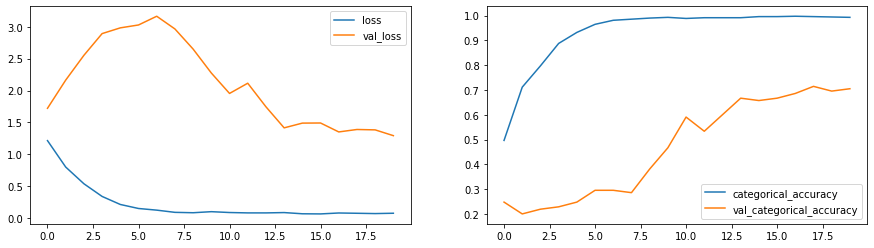

In [13]:
plot(trained_model_1)

Observation

- The accuracy on the training dataset in very high while the accuracy on the validation dataset is too less.
- This is an indication of overfitting on the training dataset.

### Model 2 : Conv2D layers + GRU Layer+ Adam optimiser + Dropout

In [14]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout=0.25


# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu'))
model.add(Dense(num_denselayers[1], activation='relu'))
model.add(Dropout(dropout))

## using GRU as the RNN model
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

In [15]:
optimiser = "Adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 15, 60, 60, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 60, 60, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 dropout (Dropout)           (None, 15, 30, 30, 16)    0         
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 30, 30, 32)   4640      
 stributed)                                           

In [16]:
print("Total Params:", model.count_params())
trained_model_2=train_model(model)

Total Params: 152453
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_369/2256448371.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.4369 - categorical_accuracy: 0.3733Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 1.96902, saving model to model_init_2023-03-1122_10_07.194785/model-00001-1.43689-0.37333-1.96902-0.20952.h5
45/45 [==============================] - 174s 4s/step - loss: 1.4369 - categorical_accuracy: 0.3733 - val_loss: 1.9690 - val_categorical_accuracy: 0.2095 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 1.1157 - categorical_accuracy: 0.5393
Epoch 00002: val_loss did not improve from 1.96902
45/45 [==============================] - 167s 4s/step - loss: 1.1157 - categorical_accuracy: 0.5393 - val_loss: 2.4553 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.8543 - categorical_accuracy: 0.6593
Epoch 00003: val_loss did not improve from 1.96902
45/45 [======================

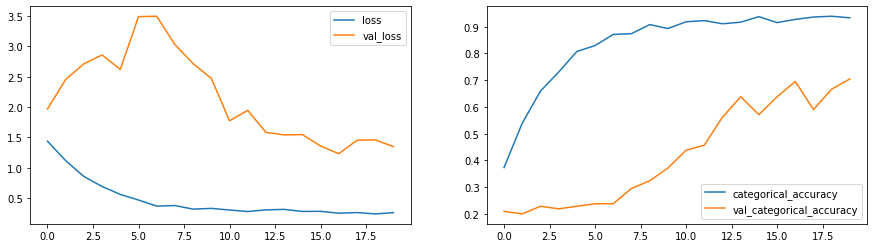

In [17]:
plot(trained_model_2)

> Observation : 
>> There is no major improvement compared to last model that is having overfitting

### Model 3 : Conv2D layers + GRU Layer+ Adam optimiser + dropout + L2 regularization

In [18]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(num_denselayers[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(dropout))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 


In [19]:
optimiser = "Adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 15, 60, 60, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 15, 60, 60, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 15, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 dropout_4 (Dropout)         (None, 15, 30, 30, 16)    0         
                                                                 
 time_distributed_29 (TimeDi  (None, 15, 30, 30, 32)   4640      
 stributed)                                           

In [20]:
print("Total Params:", model.count_params())
trained_model_3=train_model(model)

Total Params: 152453
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_369/2256448371.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 2.8628 - categorical_accuracy: 0.3837Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 3.10617, saving model to model_init_2023-03-1122_10_07.194785/model-00001-2.86277-0.38370-3.10617-0.13333.h5
45/45 [==============================] - 149s 3s/step - loss: 2.8628 - categorical_accuracy: 0.3837 - val_loss: 3.1062 - val_categorical_accuracy: 0.1333 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 2.2040 - categorical_accuracy: 0.5719
Epoch 00002: val_loss improved from 3.10617 to 2.90474, saving model to model_init_2023-03-1122_10_07.194785/model-00002-2.20398-0.57185-2.90474-0.16190.h5
45/45 [==============================] - 148s 3s/step - loss: 2.2040 - categorical_accuracy: 0.5719 - val_loss: 2.9047 - val_categorical_accuracy: 0.1619 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 1.7786 - cate

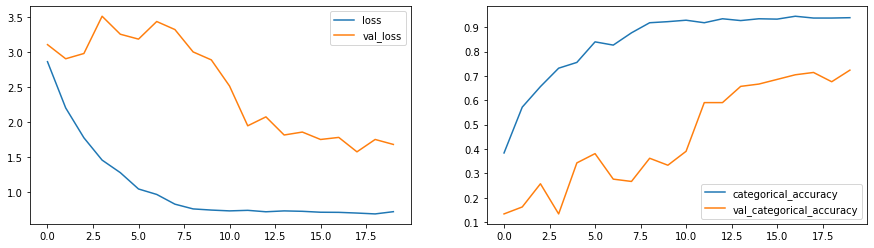

In [21]:
plot(trained_model_3)

> Observation : 
>> Val Loss is getting lower

### Model 4 : Conv2D layers + GRU Layer+ SDG optimiser + dropout + L2 regularization¶

In [12]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(num_denselayers[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(dropout))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

 # using Softmax as last layer
model.add(Dense(num_classes, activation='softmax'))

In [13]:
optimiser = "sgd" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 15, 60, 60, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 60, 60, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 dropout_4 (Dropout)         (None, 15, 30, 30, 16)    0         
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 30, 30, 32)   4640      
 stributed)                                           

In [14]:
print("Total Params:", model.count_params())
trained_model_4=train_model(model)

Total Params: 152453
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_293/2256448371.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 3.1389 - categorical_accuracy: 0.3111Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 3.28156, saving model to model_init_2023-03-1206_30_13.995581/model-00001-3.13895-0.31111-3.28156-0.22857.h5
45/45 [==============================] - 156s 3s/step - loss: 3.1389 - categorical_accuracy: 0.3111 - val_loss: 3.2816 - val_categorical_accuracy: 0.2286 - lr: 0.0100
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 2.9094 - categorical_accuracy: 0.4222
Epoch 00002: val_loss did not improve from 3.28156
45/45 [==============================] - 146s 3s/step - loss: 2.9094 - categorical_accuracy: 0.4222 - val_loss: 3.3534 - val_categorical_accuracy: 0.2190 - lr: 0.0100
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 2.7050 - categorical_accuracy: 0.4993
Epoch 00003: val_loss did not improve from 3.28156
45/45 [======================

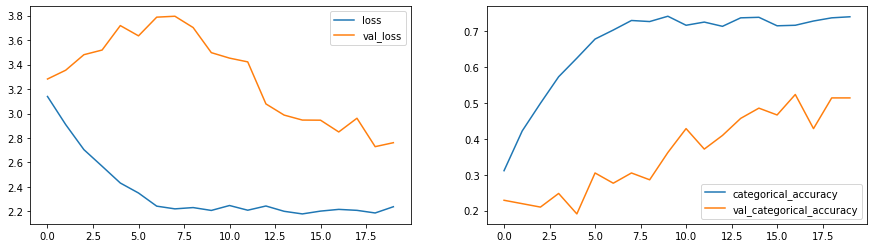

In [15]:
plot(trained_model_4)

> Observation : 
>> Increase in validation accuracy

### Model 5 : Conv3D layers + Dropout + Batch Normalization + L2 Regularization

In [16]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()


model.add(Conv3D(num_featuremaps[0], (3, 3, 3), padding = 'same', input_shape = input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size = (2, 2, 2)))
model.add(Dropout(0.25))
          
model.add(Conv3D(num_featuremaps[1], (2, 2, 2), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size = (2, 2, 2)))

model.add(Conv3D(num_featuremaps[2], (2, 2, 2), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size = (2, 2, 2)))
model.add(Dropout(0.25))
          
model.add(Flatten())
          
model.add(Dense(num_denselayers[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
          
model.add(Dense(num_denselayers[1], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
          

 # using Softmax as last layer
model.add(Dense(num_classes, activation='softmax'))

In [17]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_8 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 16)    0         
 )                                                               
                                                                 
 dropout_8 (Dropout)         (None, 7, 60, 60, 16)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)    

In [ ]:
print("Total Params:", model.count_params())
trained_model_5=train_model(model)

Total Params: 946245
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_293/2256448371.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 4.7568 - categorical_accuracy: 0.2681 Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 4.44995, saving model to model_init_2023-03-1206_30_13.995581/model-00001-4.75680-0.26815-4.44995-0.25714.h5
45/45 [==============================] - 603s 13s/step - loss: 4.7568 - categorical_accuracy: 0.2681 - val_loss: 4.4500 - val_categorical_accuracy: 0.2571 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 3.1422 - categorical_accuracy: 0.3289 
Epoch 00002: val_loss did not improve from 4.44995
45/45 [==============================] - 634s 14s/step - loss: 3.1422 - categorical_accuracy: 0.3289 - val_loss: 10.2266 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 2.8578 - categorical_accuracy: 0.3363 
Epoch 00003: val_loss did not improve from 4.44995
45/45 [================

In [ ]:
plot(trained_model_5)

> Observation : 
>> Good Performance, val_loss & train loss are almost same at the end
>> As well val_accuracy & train accuracy also touching eaching other at the end in the graph

In [ ]:
aaaa

### Model 6 : Transfer Learning + Resnet50 + dropout + GRU Layer

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

# Define model

resnet_model = ResNet50(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(resnet_model,input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))


model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1], activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 


In [ ]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

In [ ]:
print("Total Params:", model.count_params())
trained_model_6=train_model(model)

In [ ]:
plot(trained_model_6)

> Observation : 
>> Degraded the performance compared to last model

### Model 7 : Transfer Learning + VGGNET + dropout + GRU Layer

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

# Define model
vgg_model = VGG16(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(vgg_model,input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1], activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

In [ ]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

In [ ]:
print("Total Params:", model.count_params())
trained_model_7=train_model(model)

In [ ]:
plot(trained_model_7)

> Observation : 
>> Val_accuracy is more than train accuracy, and train / val loss is close enough at the end

### Model 8 : Transfer Learning + mobilenet + dropout + GRU Layer

In [ ]:
from keras.applications import  mobilenet


In [ ]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25


# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobile_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1],activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

In [ ]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

In [ ]:
print("Total Params:", model.count_params())
trained_model_8=train_model(model)

In [ ]:
plot(trained_model_8)

> Observation : 
>> Awsum : Now Model start perfroming very good as both train & val accuracy is great above 90%

### Model 9 : Transfer Learning + mobilenet + dropout + GRU Layer + Increased epoch

In [ ]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25
num_epochs = 30


# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobile_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1],activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

In [ ]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

In [ ]:
print("Total Params:", model.count_params())
trained_model_9=train_model(model)

In [ ]:
plot(trained_model_9)

> Observation : 
>> Degraded the Performance Compared to Last Model

### Model 10 : Transfer Learning + mobilenet + dropout + GRU Layer + Increased epoch + Increased Batch Size

In [ ]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25
num_epochs = 30

# increasing batch Size
batch_size = 20

# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobile_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1],activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 


In [ ]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())


In [ ]:
print("Total Params:", model.count_params())
trained_model_10=train_model(model)

In [ ]:
plot(trained_model_10)

# Selected Model

* **Train Accuracy** :   |  **Validation Accuracy** : 

* **Train Loss** :  | **Validation Loss** : 

### Model 11 : Transfer Learning + mobilenet + dropout + GRU Layer + Increased Batch Size(More)

In [ ]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25
num_epochs = 20

# increasing batch Size
batch_size = 25

# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobile_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1],activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 


In [ ]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())


In [ ]:
print("Total Params:", model.count_params())
trained_model_11=train_model(model)

In [ ]:
plot(trained_model_11)

> Observation : 
>> Almost Perfrom Like Last Model, val/ train accuracy is good no overfitting, but till now Model 8 is best

We started by building a basic CNN+RNN model without using any dropouts. GRU was selected as it has fewer parameters than LSTM, as it lacks an output gate.

• We experimented with different models by using different model configurations and hyperparameters such as introducing dropouts, using L2 regularization in combination with different optimizers.

• We also experimented with SGD() and Adam() optimizers but finally used Adam() as it lead to improvement in model’s accuracy. Due to the limited computational capacity we could not experiment with other optimizers such as Adagrad and Adadelta as these take a lot of time to run.

• We also played around with different learning rates and ReduceLROnPlateau was used to decrease the learning rate .

• To overcome the issue of overfitting we used Batch Normalization, pooling and dropout layers.

• Then we used Conv3D and experimented with different model configurations to arrive at the final model.

In [ ]:
from tensorflow import keras
model = keras.models.load_model()

In [ ]:
model.summary()

############################################## END OF PROJECT ##############################################